In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
session = tf.InteractiveSession()

from exoplanet import transit

/Users/dforeman/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [142]:
T = tf.float64

c1 = tf.constant(0.5, dtype=T)
c2 = tf.constant(0.5, dtype=T)
ld = transit.QuadraticLimbDarkening(c1, c2)

N = 1000
r = tf.constant(0.1, dtype=T)
z = (1 + r) * tf.constant(np.linspace(0.0, 1.0, N), dtype=T)

delta_exact = transit.transit_depth(ld, z, r, n_integrate=500000)
ns = 2**np.arange(1, 14)
deltas = []
for n in ns:
    deltas.append(tf.reduce_max(tf.abs(delta_exact - transit.transit_depth(ld, z, r, n_integrate=n))))
delta_z = transit.transit_depth(ld, z, r, n_integrate=1000) - delta_exact

In [141]:
# Estimate the scaling of the error
# y = np.log10(0.005 * 2 ** np.arange(9))
# Z = np.empty((len(y), len(ns)))
# for i, ror in enumerate(10**y):
#     Z[i] = np.log10(session.run(deltas, feed_dict={r: ror}))
# x = np.log10(ns)
# X, Y = np.meshgrid(x, y)
# A = np.vstack((X.flatten(), Y.flatten(), np.ones(X.size))).T
# w = np.linalg.solve(np.dot(A.T, A), np.dot(A.T, Z.flatten()))
# w

In [146]:
z_val = z.eval()
rors = np.array([0.01, 0.04, 0.16, 0.64])
ld_cs = [(0.5, 0.5), (0.1, 0.8), (0.8, 0.1)]

err_val = np.empty((len(ld_cs), len(rors), len(ns)))
err_z = np.empty((len(ld_cs), len(rors), len(z_val)))
for i, c in enumerate(ld_cs):
    for j, ror in enumerate(rors):
        fd = {r: ror, c1: c[0], c2: c[1]}
        err_val[i, j], err_z[i, j] = session.run([deltas, delta_z], feed_dict=fd)

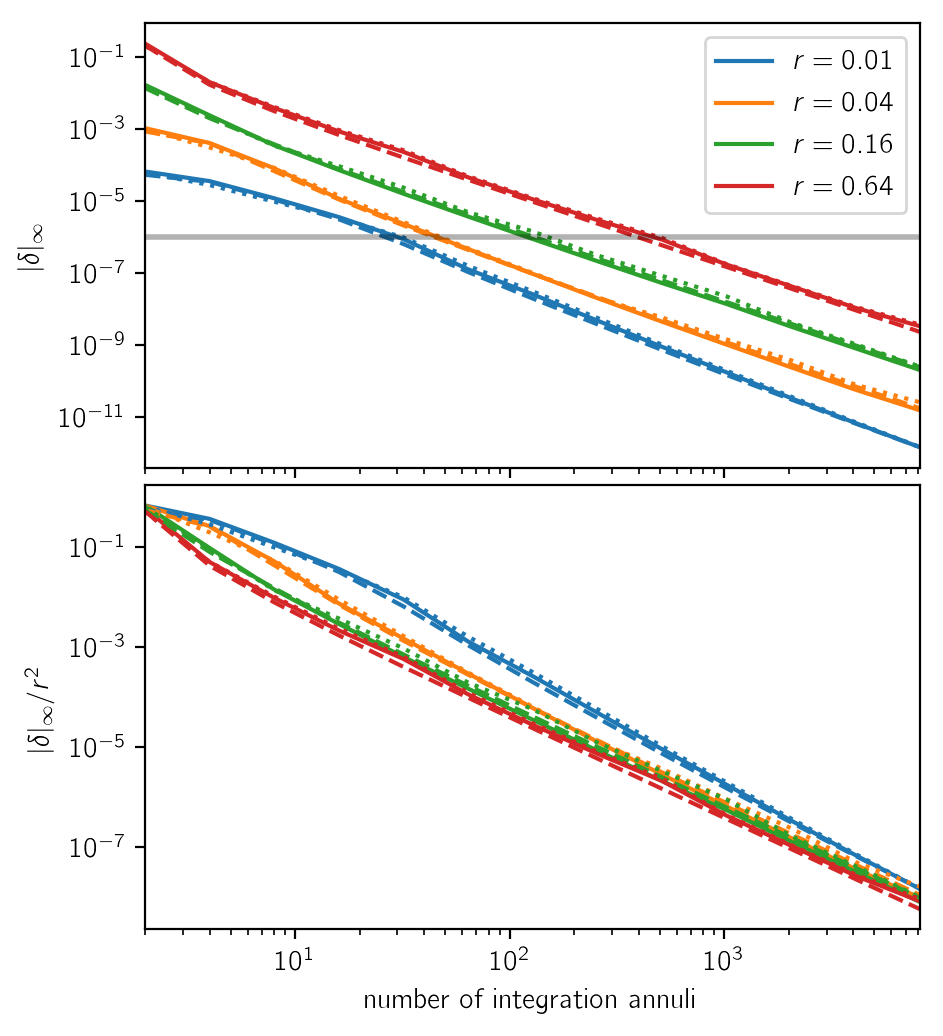

In [161]:
fig, axes = plt.subplots(2, 1, figsize=(5, 6), sharex=True)

for i, (c, s) in enumerate(zip(ld_cs, ["solid", "dashed", "dotted"])):
    for j, ror in enumerate(rors):
        fd = {r: ror, c1: c[0], c2: c[1]}
        color = "C{0}".format(j)
        label = "$r = {0:.2f}$".format(ror) if s == "solid" else None

        ax = axes[0]
        ax.loglog(ns, err_val[i, j], color=color, linestyle=s, label=label)
        
        ax = axes[1]
        ax.loglog(ns, err_val[i, j] / ror**2, color=color, linestyle=s, label=label)

axes[0].axhline(1e-6, color="k", lw=2.0, alpha=0.3)
        
axes[0].set_ylabel("$|\delta|_\infty$")
axes[1].set_ylabel("$|\delta|_\infty / r^2$")
axes[1].set_xlabel("number of integration annuli")
axes[1].set_xlim(ns.min(), ns.max())
axes[0].legend()

fig.subplots_adjust(hspace=0.04)

In [127]:
x = z.eval()
rors = [0.01, 0.04, 0.16, 0.64]
arg = transit.transit_depth(ld, z, r, n_integrate=1000) - delta_exact
y = np.empty((len(rors), len(x)))
for i, ror in enumerate(rors):
    y[i] = session.run(arg, feed_dict={r: ror})

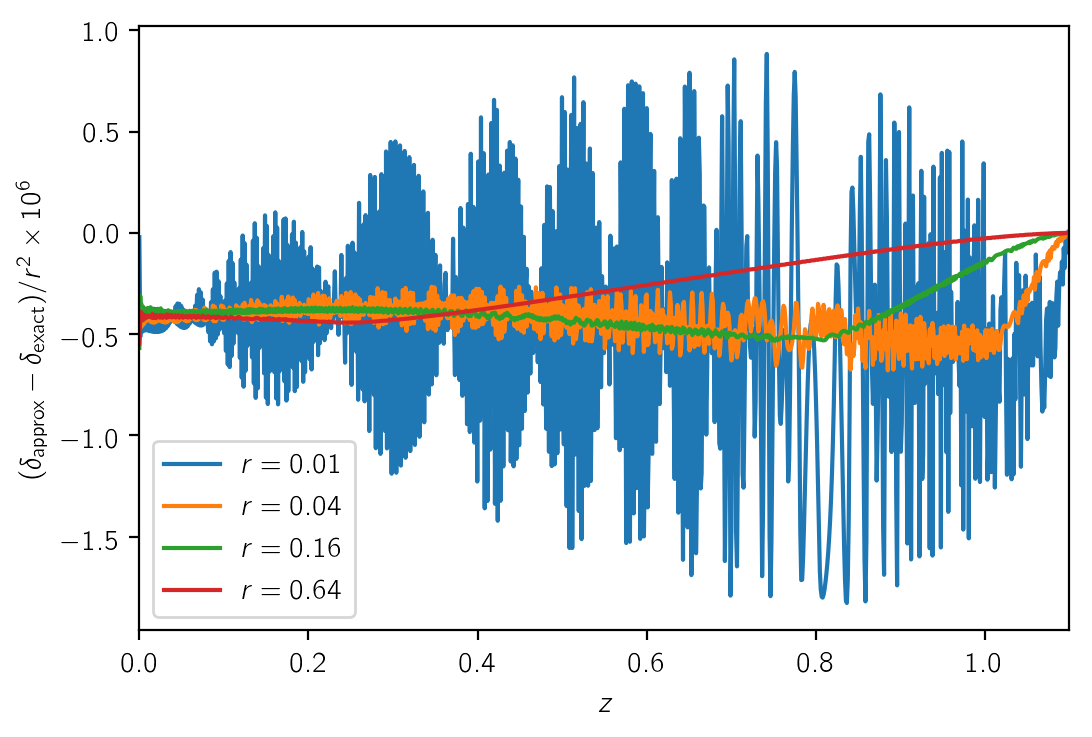

In [140]:
for i, ror in enumerate(rors):
    plt.plot(x, y[i] / np.array(ror)**2 * 1e6, label="$r = {0:.2f}$".format(ror))
plt.xlim(0, 1.1)
plt.ylabel("$(\delta_\mathrm{approx} - \delta_\mathrm{exact})/r^2 \\times 10^6$")
plt.xlabel("$z$")
plt.legend()